In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
# from https://github.com/hauser-group/odft_tools
from odft_tools.models_ccnn import (
    ClassicCNN,
    ContCNNV1,
    ContCNNV2
)

from odft_tools.layers import (
    IntegrateLayer,
    Continuous1DConvV1,
    Continuous1DConvV2
)

from odft_tools.utils import (
    plot_gaussian_weights_v1,
    plot_derivative_energy
)

data_path = '../datasets/orbital_free_DFT/'

seed = 0
tf.random.set_seed(seed)

# Load dataset
Both data .hdf5-Files can be downloaded from https://github.com/hauser-group/datasets/tree/master/orbital_free_DFT

### Training

In [2]:
with h5py.File(data_path + 'M=100_training_data.hdf5', 'r') as f:
    keys = f.keys()
    print(keys)
    # build a dict (dataset.value has been deprecated. Use dataset[()] instead.)
    data = {key:f[key][()] for key in keys}

<KeysViewHDF5 ['energies', 'potential', 'wavefunctions']>


In [3]:
x = np.linspace(0, 1, 500)
dx = x[1] - x[0]
N = 1
# density is wavefunction squared
n = np.sum(data['wavefunctions'][:, :, :N]**2, axis=-1)
# integrate using trapezoidal rule:
V = np.sum(0.5*(data['potential'][:, :-1]*n[:, :-1] 
                + data['potential'][:, 1:]*n[:, 1:])           
           * dx, axis=-1)
# kinetic energy is total energy minus potential energy
T = np.sum(data['energies'][:, :N], axis=-1) - V
# kinetic energy derivative
dT_dn = np.expand_dims(np.sum(data['energies'][:, :N], axis=-1)/N, axis=-1) - data['potential']
n = n.reshape((-1, 500, 1))

### Test Set

In [4]:
with h5py.File(data_path + 'test_data.hdf5', 'r') as f:
    keys = f.keys()
    print(keys)
    # build a dict (dataset.value has been deprecated. Use dataset[()] instead.)
    data_test = {key:f[key][()] for key in keys}

<KeysViewHDF5 ['energies', 'potential', 'wavefunctions']>


In [5]:
# density is wavefunction squared
n_test = np.sum(data_test['wavefunctions'][:, :, :N]**2, axis=-1)
# integrate using trapezoidal rule:
V_test = np.sum(0.5*(data_test['potential'][:, :-1]*n_test[:, :-1] 
                + data_test['potential'][:, 1:]*n_test[:, 1:])           
                * dx, axis=-1)
# kinetic energy is total energy minus potential energy
T_test = np.sum(data_test['energies'][:, :N], axis=-1) - V_test
# kinetic energy derivative
dT_dn_test = - data_test['potential'] + np.expand_dims(np.sum(data_test['energies'][:, :N], axis=-1)/N, axis=-1) 
n_test = n_test.reshape((-1, 500, 1))

# Define model

In [6]:
kernel_size = 100
# Feel free to use larger kernel size (Manuel used 100) and larger networks (Manuels ResNet used layers=[32, 32, 32, 32, 32, 32]).
model = ContCNNV1(layers=[32, ], kernel_size=kernel_size, dx=dx)
# Tell the model what input to expect. The first dimension (None) represents the batch size and remains undefinded.
model.build(input_shape=(None, 500, 1))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
              loss={'T': 'mse', 'dT_dn': 'mse'}, 
              loss_weights={'T': 0.2, 'dT_dn': 1.0}, # As recommended by Manuel: scale the loss in T by 0.2
              metrics={'T': ['mae'], 'dT_dn': ['mae']})
model.summary()

Model: "cont_cnn_v1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
continuous1d_conv_v1 (Contin multiple                  3232      
_________________________________________________________________
continuous1d_conv_v1_1 (Cont multiple                  3201      
_________________________________________________________________
integrate_layer_1 (Integrate multiple                  0         
Total params: 6,433
Trainable params: 6,433
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Build a dataset that repeats the data (cast to float32) 10 times to reduce output in model.fit().
# Note that this step is not necessary, you could simply feed the numpy arrays into the model.fit() method.
training_dataset = tf.data.Dataset.from_tensor_slices((n.astype(np.float32), {'T': T.astype(np.float32), 'dT_dn': dT_dn.astype(np.float32)})).batch(100).repeat(10)

result_type = '/ContCNNV1/32_1/'

In [8]:
# Beware when comparing the results to our paper. The output here is in Hartree!
weights_before_train = model.layers[0].get_weights()[0]
model.fit(training_dataset, epochs=100, verbose=2, validation_data=(n_test, {'T': T_test, 'dT_dn': dT_dn_test}), validation_freq=10)
weights_after_train = model.layers[0].get_weights()[0]

Epoch 1/100
10/10 - 4s - loss: 182.9715 - T_loss: 406.8027 - dT_dn_loss: 101.6109 - T_mae: 16.5434 - dT_dn_mae: 7.9514
Epoch 2/100
10/10 - 4s - loss: 27.7705 - T_loss: 14.9861 - dT_dn_loss: 24.7733 - T_mae: 3.4079 - dT_dn_mae: 3.4674
Epoch 3/100
10/10 - 5s - loss: 33.8873 - T_loss: 40.9224 - dT_dn_loss: 25.7028 - T_mae: 6.3892 - dT_dn_mae: 3.4936
Epoch 4/100
10/10 - 4s - loss: 32.1937 - T_loss: 33.4239 - dT_dn_loss: 25.5090 - T_mae: 5.7620 - dT_dn_mae: 3.4804
Epoch 5/100
10/10 - 5s - loss: 29.7371 - T_loss: 18.3750 - dT_dn_loss: 26.0620 - T_mae: 4.2549 - dT_dn_mae: 3.5170
Epoch 6/100
10/10 - 5s - loss: 28.4560 - T_loss: 8.3412 - dT_dn_loss: 26.7877 - T_mae: 2.8544 - dT_dn_mae: 3.5692
Epoch 7/100
10/10 - 5s - loss: 27.8480 - T_loss: 3.5303 - dT_dn_loss: 27.1419 - T_mae: 1.8454 - dT_dn_mae: 3.5983
Epoch 8/100
10/10 - 5s - loss: 27.2131 - T_loss: 1.4997 - dT_dn_loss: 26.9131 - T_mae: 1.1855 - dT_dn_mae: 3.5867
Epoch 9/100
10/10 - 5s - loss: 26.2420 - T_loss: 0.5699 - dT_dn_loss: 26.1280 -

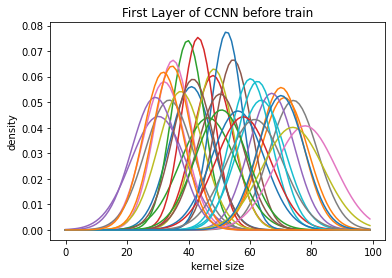

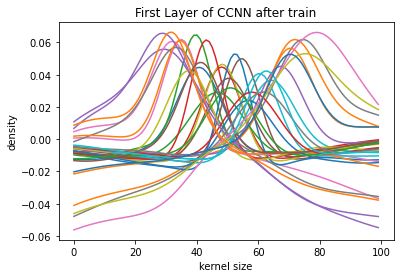

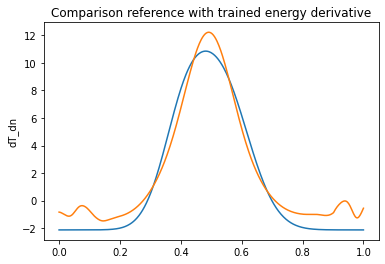

In [22]:
def plot_gaussian_weights_v1(weights, result_type, before_after):
    plt.ylabel('density')
    plt.xlabel('kernel size')
    plt.title('First Layer of CCNN '+ before_after +' train')
    plt.plot(weights[:, 0, :])
    plt.savefig('layer_ccnV1_'+ before_after +'.png')
    plt.show()

import os
def plot_derivative_energy(x, dT_dn, model, n, result_type):
    if not os.path.exists('results' + result_type):
        os.makedirs('results' + result_type)

    plt.plot(x, dT_dn[0])
    plt.plot(x, tf.squeeze(model(n[0].reshape((1, 500, 1)).astype(np.float32))['dT_dn']))
    plt.ylabel('dT_dn')
    plt.title('Comparison reference with trained energy derivative')
    plt.savefig('ccnnV1_energy_derivatice.png')
    plt.show()

plot_gaussian_weights_v1(weights_before_train, None, 'before')
plot_gaussian_weights_v1(weights_after_train, None, 'after')

plot_derivative_energy(x, dT_dn, model, n, result_type)

## Inspect results
The prediction by the CNN exhibits rapid oscillations, which we hope to eliminate by going from a convolution with a discrete kernel towards a convolution with a continuous function

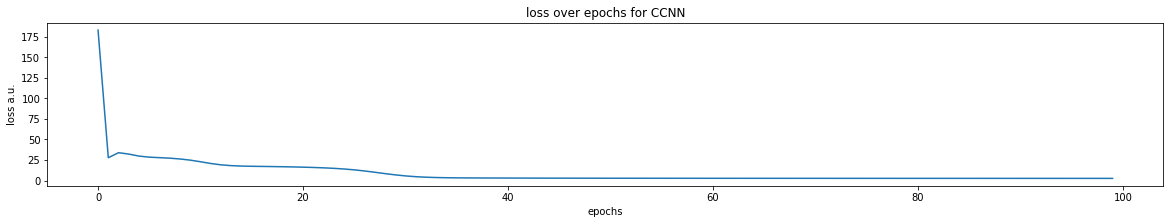

In [51]:
import pandas as pd
df = pd.DataFrame([])
df['loss'] = model.history.history['loss']
df['dT_dn_loss'] = model.history.history['dT_dn_loss']
df['T_loss'] = model.history.history['T_loss']

plt.figure(figsize=(20, 3))

plt.plot(df['loss'])
plt.xlabel('epochs')
plt.ylabel('loss a.u.')
plt.title('loss over epochs for CCNN')
plt.savefig('loss_CNN.png')
plt.show()

# plt.figure(figsize=(20, 3))

# plt.plot(df['T_loss'])

# plt.xlabel('epochs')
# plt.ylabel('loss a.u.')
# plt.title('kinetic energy loss over epochs CCNN')
# plt.show()

# plt.figure(figsize=(20, 3))

# plt.plot(df['dT_dn_loss'])

# plt.xlabel('epochs')
# plt.ylabel('loss a.u.')
# plt.show()